# Median equality test applied to varying mixing weights models

Margaux Thorez

## 1- Contextualization

In order to understand whether two populations are homogeneous, we carry out a test of equality of the median. Still in the case $K=M=2$, let's note $\mu_1$ and $\mu_2$ the medians of the durations of seack leaves for the two groups 1 and 2. The null hypothesis $H_0$ is that the two groups have equal medians. We therefore have :
 $$ H_0 : \mu_1 = \mu_2   \hspace{0.4cm}  \mbox{ vs}  \hspace{0.4cm}  H_1 : \mu_1 \neq \mu_2. $$ 

Since the median is an M-estimator and M-estimators verify properties such as the central limit theorem, we obtain the following test statistic:
$$ T_m^{*} = \frac{\hat{\mu}_1 - \hat{\mu}_2}{\sqrt{V^{*}}},$$
where $V^{*} = \frac{1}{n}\left(Var(\hat{\mu}_1) + Var(\hat{\mu}_2)  -2Cov(\hat{\mu}_1, \hat{\mu}_2)\right)$, with $\alpha = \frac{n}{n_A}$ and $\beta = \frac{n}{n_B}$ :

- $Var(\hat{\mu}_1)  = \frac{1}{f_1(\mu_1)^2}\left(\frac{a_1(A)^2}{\alpha}S_A(\mu_1)(1 - S_A(\mu_1)) + \frac{a_1(B)^2}{\beta}S_B(\mu_1)(1 - S_B(\mu_1))\right)$;
- $Var(\hat{\mu}_2)  = \frac{1}{f_2(\mu_2)^2}\left(\frac{a_2(A)^2}{\alpha}S_A(\mu_2)(1 - S_A(\mu_2)) + \frac{a_2(B)^2}{\beta}S_B(\mu_2)(1 - S_B(\mu_2))\right)$;
- $Cov(\hat{\mu}_1, \hat{\mu}_2) = \frac{1}{f_1(\mu_1)f_2(\mu_2)}\left(\frac{a_1(A)a_2(A)}{\alpha}S_A(\mu)(1 - S_A(\mu)) + \frac{a_1(B)a_2(B)}{\beta}S_B(\mu)(1 - S_B(\mu)\right).$ 


In practice, $V^{*}$ is unknown because we don't know $f_1$, $f_2$, $S_A$, $S_B$, $\mu_1$ and $\mu_2$. We can therefore use consistent estimators of these variables and Slustsky to replace $V^{*}$ with a consistent estimator, we have : 

$$ T_m^{*} = \frac{\hat{\mu}_1 - \hat{\mu}_2}{\sqrt{\hat{V}^{*}}},$$
where $\hat{V}^{*} = \frac{1}{n}\left(\widehat{Var}(\hat{\mu}_1) + \widehat{Var}(\hat{\mu}_2)  -2\widehat{Cov}(\hat{\mu}_1, \hat{\mu}_2)\right)$, with $\hat{\mu}_1$ et $\hat{\mu}_2$ the estimators of groups 1 and 2, $\hat{\mu}$ a consistent estimator of $\mu = \mu_1 = \mu_2$, $\alpha = \frac{n}{n_A}$ and $\beta = \frac{n}{n_B}$ :

- $\widehat{Var}(\hat{\mu}_1)  = \frac{1}{\hat{f}_1(\hat{\mu}_1)^2}\left(\frac{a_1(A)^2}{\alpha}\hat{S}_A(\hat{\mu}_1)(1 - \hat{S}_A(\hat{\mu}_1)) + \frac{a_1(B)^2}{\beta}\hat{S}_B(\hat{\mu}_1)(1 - \hat{S}_B(\hat{\mu}_1))\right)$;
- $\widehat{Var}(\hat{\mu}_2)  = \frac{1}{\hat{f}_2(\hat{\mu}_2)^2}\left(\frac{a_2(A)^2}{\alpha}\hat{S}_A(\hat{\mu}_2)(1 - \hat{S}_A(\hat{\mu}_2)) + \frac{a_2(B)^2}{\beta}\hat{S}_B(\hat{\mu}_2)(1 - \hat{S}_B(\hat{\mu}_2))\right)$;
- $\widehat{Cov}(\hat{\mu}_1, \hat{\mu}_2) = \frac{1}{\hat{f}_1(\hat{\mu}_1)\hat{f}_2(\hat{\mu}_2)}\left(\frac{a_1(A)a_2(A)}{\alpha}\hat{S}_A(\hat{\mu})(1 - \hat{S}_A(\hat{\mu})) + \frac{a_1(B)a_2(B)}{\beta}\hat{S}_B(\hat{\mu})(1 - \hat{S}_B(\hat{\mu})\right).$ 

We showed that under the null hypothesis $H_0$, the distribution of $T_m^{*}$ asymptotically follows the Gaussian distribution, i.e. 
$$ T_m^{*} \xrightarrow[n\rightarrow +\infty ]{\mathcal{L}} \mathcal{N}(0,1),$$

We will illustrate this result with a few simulations. In the case with censorship, this is not the good normalisation but it gives us an idea of the result. 

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.stats import norm
from tqdm import tqdm

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_notebook_menu()

## 3- Base model - optimized functions

### Survival functions

In [3]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [4]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [5]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [6]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [7]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [8]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [9]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 ou 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [10]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [11]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- Median equality Test without censorship 

For now, we juste take into account the exponnentiel distribution to facilitate the computation of the expected median. 

In [12]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    law = "exponnential" 
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]
    
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
       
    #Kaplan-Meier
    X = np.concatenate((X_A,X_B))  
    Y = X
    Y_ind = [True for i in range(len(Y))]
    
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
    
    #Maiboroda's coefficients
    if nA == nB:
        #This method can be use when na = nB
        X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
        X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)
    else : 
        #This method is more time-consuming but is true in the general case. 
        prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
        prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
        A = np.asmatrix([prob_X1,prob_X2])
        A_trans = np.transpose(A)
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
        prob.solve(solver = cp.SCS, verbose=True)
        X_1 = X.value
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
        prob.solve(solver = cp.SCS, verbose=True)
        X_2 = X.value
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)

    #Construction of S_mx using our Kaplan Meier estimator 
    S_1_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
    S_2_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
    
    if model == "Ryzhov":
        S_1_est = S_1_est 
        S_2_est = S_2_est 
    elif model =="Maiboroda":
        S_1_est = S_1_mx
        S_2_est = S_2_mx
    else :
        print("Please, select a valid model")
        
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction=direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction=direction)
    
    #Simulation parameters
    n = nA + nB
    alpha = nA/n
    beta = nB/n
    med_1 = lambd1*np.log(2)
    med_2 = lambd2*np.log(2)
    
    #Find the median for group 1
    i = 0
    while S_1_est[i] > 0.5:
        i+=1
    res1 = time1[i-1]
    sAB1 = (((M_inv[0][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[0][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta
    f1 = M_inv[0][0]*stats.expon.pdf(med_1, scale=lambd1) + M_inv[0][1]*stats.expon.pdf(med_1, scale=lambd2)
    ss1 = M_inv[0][0]*M_inv[1][0]*(S_A_est[i-1])*(1 - S_A_est[i-1])/alpha + M_inv[0][1]*M_inv[1][1]*(S_B_est[i-1])*(1 - S_B_est[i-1])/beta
    
    #Find the median for group 2
    i = 0
    while S_2_est[i] > 0.5:
        i+=1
    res2 = time1[i-1]
    sAB2 = (((M_inv[1][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[1][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta
    f2 = M_inv[1][0]*stats.expon.pdf(med_2, scale=lambd1) + M_inv[1][1]*stats.expon.pdf(med_2, scale=lambd2)
    ss2 = M_inv[0][0]*M_inv[1][0]*(S_A_est[i-1])*(1 - S_A_est[i-1])/alpha + M_inv[0][1]*M_inv[1][1]*(S_B_est[i-1])*(1 - S_B_est[i-1])/beta
    
    ss = (ss1 + ss2)/2
    v = (sAB1/(f1**2) + sAB2/(f2**2) - 2*ss/(f1*f2))
    result = sqrt(n)*(res1 - res2)/sqrt(v)

    return (result)

In [13]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    # Initialisation des paramètres de parallélisation
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    # Entrainement de l'Estimateur sur les différentes observations de Train
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, model = model, direction = direction) for k in range(K)])

    #Concatenation into array
    List_results = np.array([result for result in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié

    #return ComputedBlocks
    return List_results

#### Parameters choice

In [14]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

model = "Ryzhov"

In [15]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [16]:
#Number of repetitions
K = 1000

#### Results of one simulation

In [17]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction)

0.3888024399859293

#### Results of K simulations

In [18]:
List_results = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [19]:
List_results = List_results.tolist()

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $T_m^{*}$')

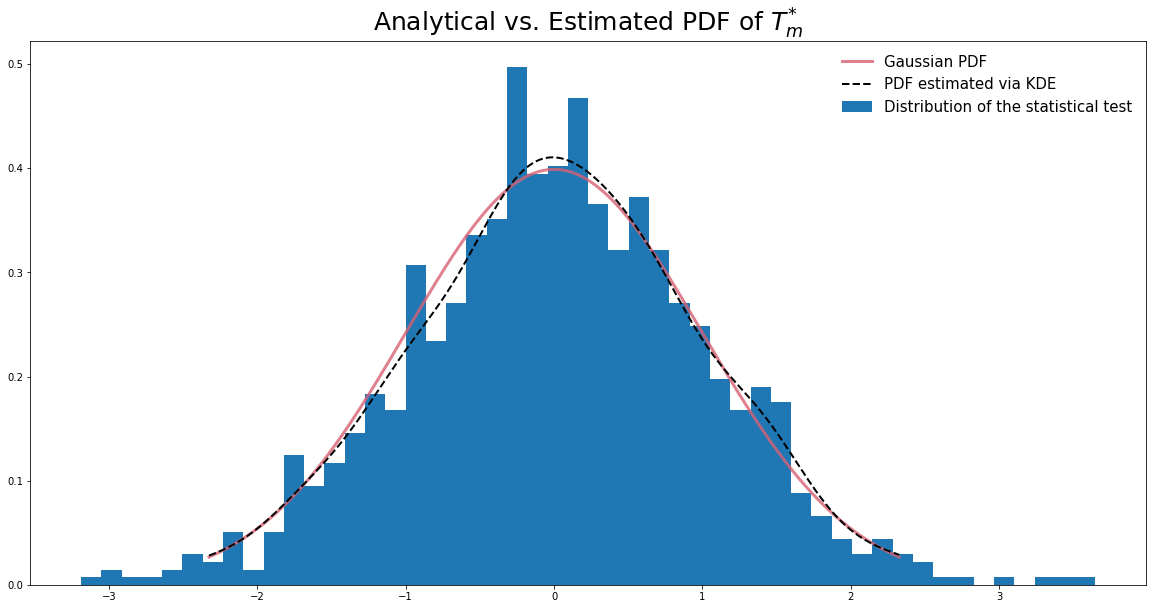

In [20]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $T_m^{*}$', fontsize = 25)

In [21]:
#Compute mean of the statistic 
print(np.mean(List_results))

#Compute variance of the statistic 
print(np.var(List_results))

0.02847747926143765
0.9957321162193653


In [22]:
# Calculate the skewness
print(skew(List_results, axis=0, bias=True))

# Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

0.01006478854625772
3.235106343980914


In [23]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.03251108015855775, pvalue=0.23594852829198631, statistic_location=-0.3570930325442321, statistic_sign=-1)

## 5- Median equality Test with censorship 

For now, we juste take into account the exponnentiel distribution to facilitate the computation of the expected median.

In [24]:
def RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Initialization of matrices C_A and C_B
    C_A = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nA)
    C_B = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nB)
    
    #Kaplan-Meier estimators
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initializing Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Updating Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    
    #Initialization of matrices X, C, Y and Y_ind
    X = np.concatenate((X_A,X_B))  
    C = np.concatenate((C_A,C_B)) 
    Y = X
    Y_ind = np.full(shape=Y.shape, fill_value=False)
    #Updating Y_ind
    Y = np.minimum(C, X)
    Y_ind = Y_ind_Allocation(Y_ind=Y_ind, Y=Y, C=C, X=X)
    #Sorting Y
    m = Y.argsort()
    Y = Y[m]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
    
    #Maiboroda's coefficients
    if nA == nB:
        #This method can be use when na = nB
        X_1 = [2*M_inv[0][0] for i in range(0,nA)] + [2*M_inv[0][1] for i in range(0,nB)]
        X_2 = [2*M_inv[1][0] for i in range(0,nA)] + [2*M_inv[1][1] for i in range(0,nB)]
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)
    else : 
        #This method is more time-consuming but is true in the general case. 
        prob_X1 = [P_A1 for i in range(0,n1)] + [P_B1 for i in range(0,n2)]
        prob_X2 = [P_A2 for i in range(0,n1)] + [P_B2 for i in range(0,n2)]
        A = np.asmatrix([prob_X1,prob_X2])
        A_trans = np.transpose(A)
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [n , 0] ])
        prob.solve(solver = cp.SCS, verbose=True)
        X_1 = X.value
        N = A.shape[1]
        X = cp.Variable(N)
        prob = cp.Problem(cp.Minimize(cp.sum(X)), [A @ X == [0 , n] ])  
        prob.solve(solver = cp.SCS, verbose=True)
        X_2 = X.value
        X_1 = np.array(X_1)
        X_2 = np.array(X_2)


    #Construction of S_mx using our Kaplan Meier estimator 
    S_1_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_1[m],time=time1, direction=direction)
    S_2_mx = kaplan_meier_mx_smoothed(Y=Y,Y_ind=Y_ind,X_X=X_2[m],time=time1, direction=direction)
    
    if model == "Ryzhov":
        S_1_est = S_1_est 
        S_2_est = S_2_est 
    elif model =="Maiboroda":
        S_1_est = S_1_mx
        S_2_est = S_2_mx
    else :
        print("Please, select a valid model")
        
    S_1_est = S_1_est_mx_Threshold(S_1_est, direction=direction)
    S_2_est = S_1_est_mx_Threshold(S_2_est, direction=direction)
    
    #Simulation parameters
    n = nA + nB
    alpha = nA/n
    beta = nB/n
    med_1 = lambd1*np.log(2)
    med_2 = lambd2*np.log(2)
    
    #Find the median for group 1
    i = 0
    while S_1_est[i] > 0.5:
        i+=1
    res1 = time1[i-1]
    sAB1 = (((M_inv[0][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[0][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta
    f1 = M_inv[0][0]*stats.expon.pdf(med_1, scale=lambd1) + M_inv[0][1]*stats.expon.pdf(med_1, scale=lambd2)
    ss1 = M_inv[0][0]*M_inv[1][0]*(S_A_est[i-1])*(1 - S_A_est[i-1])/alpha + M_inv[0][1]*M_inv[1][1]*(S_B_est[i-1])*(1 - S_B_est[i-1])/beta
    
    #Find the median for group 2
    i = 0
    while S_2_est[i] > 0.5:
        i+=1
    res2 = time1[i-1]
    sAB2 = (((M_inv[1][0])**2)*(S_A_est[i-1])*(1 - S_A_est[i-1]))/alpha + (((M_inv[1][1])**2)*(S_B_est[i-1])*(1 - S_B_est[i-1]))/beta
    f2 = M_inv[1][0]*stats.expon.pdf(med_2, scale=lambd1) + M_inv[1][1]*stats.expon.pdf(med_2, scale=lambd2)
    ss2 = M_inv[0][0]*M_inv[1][0]*(S_A_est[i-1])*(1 - S_A_est[i-1])/alpha + M_inv[0][1]*M_inv[1][1]*(S_B_est[i-1])*(1 - S_B_est[i-1])/beta
    
    ss = (ss1 + ss2)/2
    v = (sAB1/(f1**2) + sAB2/(f2**2) - 2*ss/(f1*f2))
    result = sqrt(n)*(res1 - res2)/sqrt(v)

    return (result)

In [25]:
def RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    # Initialisation des paramètres de parallélisation
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    # Entrainement de l'Estimateur sur les différentes observations de Train
    ComputedBlocks = ParallelSetUp([delayed(RunSimulationCensorship)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, model = model, direction = direction) for k in range(K)])

    #Concatenation into array
    List_results = np.array([result for result in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié

    #return ComputedBlocks
    return List_results

#### Parameters choice

In [26]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Censorship parameters
lambdC = 500

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

model = "Ryzhov"

In [27]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


In [28]:
#Number of repetitions
K = 1000

#### Results of one simulation

In [29]:
RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction)

-1.425379951923487

#### Results of K simulations

In [30]:
List_results= RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, model, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [31]:
List_results = List_results.tolist()

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $T_m^{*}$')

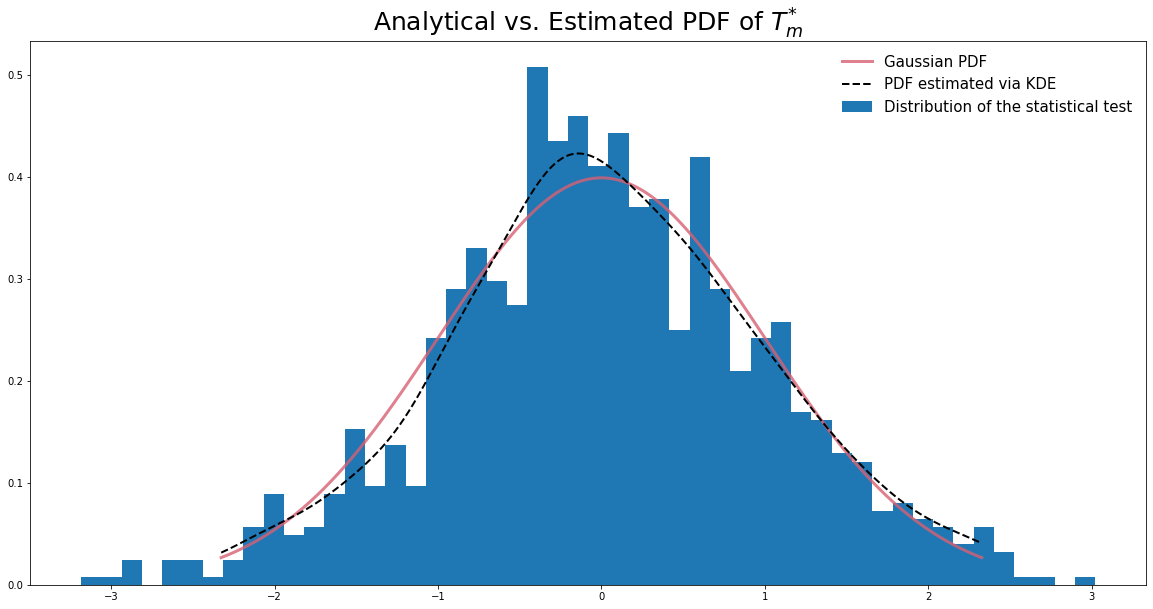

In [32]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $T_m^{*}$', fontsize = 25)

In [33]:
#Compute mean of the statistic
print(np.mean(List_results))

#Compute variance of the statistic
print(np.var(List_results))

0.020964579336928687
0.9906555537317946


In [34]:
#Calculate the skewness
print(skew(List_results, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

-0.045597750926953694
3.1215324275764753


In [35]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.03137639539697379, pvalue=0.2727306329536304, statistic_location=-0.44440086136765095, statistic_sign=-1)